# Multi-class Classification and Neural Networks

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
from scipy.optimize import minimize
%matplotlib inline

## 1 Multi-class classification

In [2]:
df = sio.loadmat('ex3data1.mat')

In [3]:
X = df['X']
y = df['y']

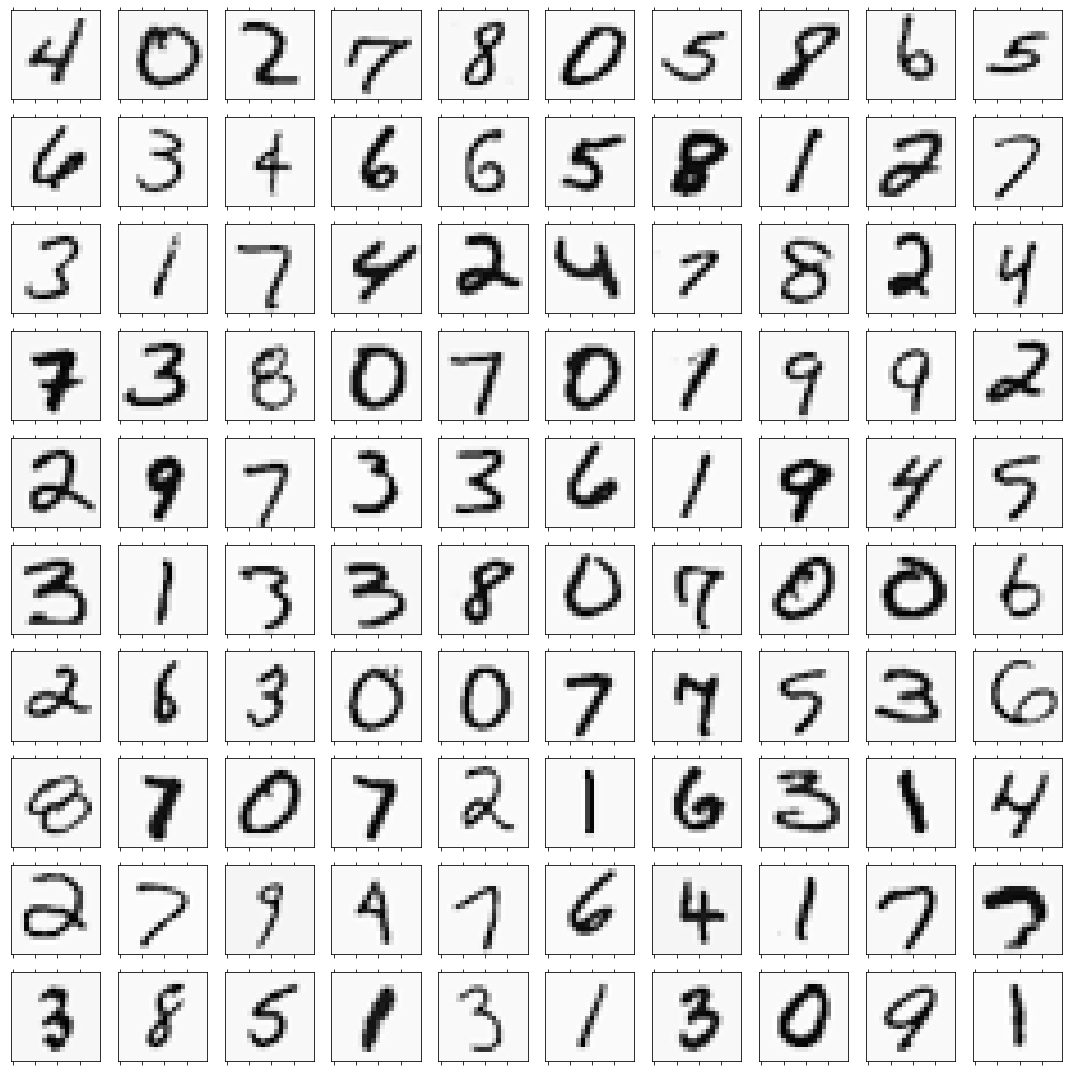

In [4]:
fig, ax = plt.subplots(10, 10, figsize=(15, 15))
for i, a in enumerate(ax.ravel()):
    j = np.random.randint(0,X.shape[0])
    a.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, 
                  left=False, labelleft=False)
    a.matshow(np.transpose(X[j,:].reshape(20,20)), cmap=plt.cm.Greys)
plt.tight_layout()

In [5]:
np.unique(y)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [6]:
# Was originally designed for octave, such that 0 was labelled as 10
y[y == 10] = 0

In [7]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

$J(\theta) = \frac{1}{m}\sum_{i=1}^{m} \left [ -y^{(i)}\log{(h_{\theta}(x^{(i)}))} - (1 - y^{(i)}) \log{(1 - h_{\theta}(x^{(i)}))} \right ] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$

$\frac{\delta J(\theta)}{\delta \theta_{j}} = \frac{1}{m} \sum^{m}_{i=1} \left ( h_{\theta} (x^{(i)} - y^{(i)} \right )x_{j}^{(i)} + \frac{\lambda}{m}\theta_{j}$

Vectorized version

$\frac{\delta J(\theta)}{\delta \theta_{j}} = \frac{1}{m} X^{T} ( X\theta - y) + \frac{\lambda}{m}\theta_{j}$

In [8]:
def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def lrCostFunction(theta, X, y, l):
    h = sigmoid(np.matmul(X,theta))
    J = ( np.matmul(-np.transpose(y) , np.log(h)) - np.matmul(np.transpose(1-y), np.log(1-h)) + sum(l*0.5*theta[1:]**2) ) / len(y)
    return J.ravel()
    
def lrGradFunction(theta, X, y, l):
    h = sigmoid(np.matmul(X,theta)).reshape(-1,1)
    grad = np.matmul(np.transpose(X), (h -y))
    grad[1:] += l*theta[1:].reshape(-1,1)
    grad /= len(y)
    return grad.ravel()

In [9]:
# Test case
# Expected cost 2.534819
theta_t = np.array([-2., -1., 1., 2.]).reshape(-1,1)
X_t = np.hstack( (np.ones((5,1)), np.linspace(0.1,1.5,15).reshape(3,5).transpose()) )
y_t = np.array([1,0,1,0,1]).reshape(-1,1)
l_t = 3.
lrCostFunction(theta_t, X_t, y_t, l_t)

array([2.5348194])

In [10]:
# Expected gradient: 0.146561 -0.548558 0.724722 1.398003
lrGradFunction(theta_t, X_t, y_t, l_t)

array([ 0.14656137, -0.54855841,  0.72472227,  1.39800296])

In [11]:
minimize_result = minimize(lrCostFunction, theta_t, method="CG", jac=lrGradFunction,
                             args=(X_t, (y_t == 9).astype(int), l_t), options={"maxiter": 400})

In [12]:
minimize_result.x

array([-1.32911470e+01,  8.49815844e-05,  6.09367801e-05,  8.21170684e-05])

In [13]:
def oneVsAll(X, y, num_labels, l):
    X = np.hstack((np.ones((len(y),1)), X))
    all_theta = np.zeros((num_labels, X.shape[1]))
    
    for k in range(num_labels):
        initial_theta = np.zeros((X.shape[1],1))
        minimize_result = minimize(lrCostFunction, initial_theta, method="CG", jac=lrGradFunction,
                             args=(X, (y == k).astype(int), l), options={"maxiter": 500})
        all_theta[k,:] = minimize_result.x
        
    return all_theta

In [14]:
l = 0.1
all_theta = oneVsAll(X, y, 10, l)

In [15]:
def predictOneVsAll(all_theta, X):
    X = np.hstack((np.ones((len(y),1)), X))
    pred = np.zeros(X.shape[0]).reshape(-1,1)
    for i in range(X.shape[0]):
        pred[i] = np.argmax( sigmoid( np.matmul( X[i,:], np.transpose(all_theta)) ) )
    return pred

In [16]:
pred = predictOneVsAll(all_theta, X)

In [17]:
print("Training accuracy: {0:.3f}".format(np.mean(pred == y)))

Training accuracy: 0.965


## 2 Multiclass with Scikit-learn

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
df = sio.loadmat('ex3data1.mat')
X = df['X']
y = pd.get_dummies(df['y'].ravel())

In [19]:
y[0] = y[10]
y.drop(10, axis=1, inplace=True)
y.head()

,1,2,3,4,5,6,7,8,9,0
0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,1


In [20]:
# TODO: adjust regularization via grid search
lr = OneVsRestClassifier(LogisticRegression(C=100, tol=1e-6))
lr.fit(X, y)

OneVsRestClassifier(estimator=LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=1e-06,
          verbose=0, warm_start=False),
          n_jobs=1)

In [21]:
print("Training accuracy: {0:.3f}".format(lr.score(X,y)))

Training accuracy: 0.925


## 3 Neural networks (Previously trained model)

In [22]:
df = sio.loadmat('ex3weights.mat')

In [23]:
Theta1 = df['Theta1']
Theta2 = df['Theta2']

In [24]:
Theta1.shape

(25, 401)

In [25]:
Theta2.shape

(10, 26)

In [26]:
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

In [27]:
df = sio.loadmat('ex3data1.mat')
X = df['X']
y = df['y']
# Was originally designed for octave, such that 0 was labelled as 10
m = len(y)

### 3.1 Feedforward propogation and predction
We have the training weights from a pre-trained model.

Input layer

$a^{(1)} = x$

Hidden layer

$z^{(2)} = \Theta^{(1)}a^{(1)}$

$a^{(2)} = g(z^{(2)})$

Output layer

$z^{(3)} = \Theta^{(2)}a^{(2)}$

$a^{(3)} = g(z^{(3)}) = h_{\theta}(x)$

In [28]:
def predict(Theta1, Theta2, X):
    
    m = X.shape[0]
    p = np.zeros((m, 1))
    
    # Input layer
    a1_0 = np.ones((m,1))
    a1 = np.hstack((a1_0, X))

    # Hidden layer
    z2 = np.matmul(Theta1, a1.transpose())
    a2_0 = np.ones((m,1))
    a2 = np.hstack((a2_0, sigmoid(z2).transpose()))

    # Output layer
    z3 = np.matmul(Theta2, a2.transpose())
    a3 = sigmoid(z3)
    
    for i in range(m):
        # Model was trained when labels had images with 0 labeled as 10
        p[i] = np.argmax(a3[:,i])+1
        
    return p

In [29]:
pred = predict(Theta1, Theta2, X)

In [30]:
print("Training set accuracy: {0:.3f}".format(np.mean(pred == y)))

Training set accuracy: 0.975
